# Ground truth for fuglene

In [19]:
'''
9286 158.Bay_breasted_Warbler/Bay_Breasted_Warbler_0011_159736.jpg
9286 65.0 92.0 353.0 213.0

9273 158.Bay_breasted_Warbler/Bay_Breasted_Warbler_0100_797142.jpg
9273 202.0 116.0 256.0 180.0

10840 184.Louisiana_Waterthrush/Louisiana_Waterthrush_0022_177397.jpg
10840 85.0 85.0 253.0 176.0

3344 058.Pigeon_Guillemot/Pigeon_Guillemot_0043_39861.jpg
3344 75.0 61.0 244.0 278.0

3350 058.Pigeon_Guillemot/Pigeon_Guillemot_0109_39872.jpg
3350 71.0 15.0 139.0 181.0

11068 188.Pileated_Woodpecker/Pileated_Woodpecker_0027_179956.jpg
11068 76.0 31.0 320.0 467.0

7446 127.Savannah_Sparrow/Savannah_Sparrow_0093_118267.jpg
7446 163.0 95.0 133.0 278.0

10531 179.Tennessee_Warbler/Tennessee_Warbler_0022_174799.jpg
10531 78.0 119.0 246.0 153.0

10512 179.Tennessee_Warbler/Tennessee_Warbler_0067_174999.jpg
10512 122.0 127.0 255.0 217.0

11691 199.Winter_Wren/Winter_Wren_0113_189558.jpg
11691 185.0 32.0 208.0 258.0
'''

'\n9286 158.Bay_breasted_Warbler/Bay_Breasted_Warbler_0011_159736.jpg\n9286 65.0 92.0 353.0 213.0\n\n9273 158.Bay_breasted_Warbler/Bay_Breasted_Warbler_0100_797142.jpg\n9273 202.0 116.0 256.0 180.0\n\n10840 184.Louisiana_Waterthrush/Louisiana_Waterthrush_0022_177397.jpg\n10840 85.0 85.0 253.0 176.0\n\n3344 058.Pigeon_Guillemot/Pigeon_Guillemot_0043_39861.jpg\n3344 75.0 61.0 244.0 278.0\n\n3350 058.Pigeon_Guillemot/Pigeon_Guillemot_0109_39872.jpg\n3350 71.0 15.0 139.0 181.0\n\n11068 188.Pileated_Woodpecker/Pileated_Woodpecker_0027_179956.jpg\n11068 76.0 31.0 320.0 467.0\n\n7446 127.Savannah_Sparrow/Savannah_Sparrow_0093_118267.jpg\n7446 163.0 95.0 133.0 278.0\n\n10531 179.Tennessee_Warbler/Tennessee_Warbler_0022_174799.jpg\n10531 78.0 119.0 246.0 153.0\n\n10512 179.Tennessee_Warbler/Tennessee_Warbler_0067_174999.jpg\n10512 122.0 127.0 255.0 217.0\n\n11691 199.Winter_Wren/Winter_Wren_0113_189558.jpg\n11691 185.0 32.0 208.0 258.0\n'

In [21]:
import torch
from torchvision.models import resnet18, resnet34
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchcam.methods import SmoothGradCAMpp
from torchvision.io import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp, LayerCAM

# https://frgfm.github.io/torch-cam/methods.html#torchcam.methods.SmoothGradCAMpp
# I believe this is smoothgrad from the lecture
from PIL import Image
from torchvision import transforms
import cv2
import glob
import operator

## import the necessary packages
from collections import namedtuple
import numpy as np
import cv2  # pip install opencv-python
# from google.colab.patches import cv2_imshow

In [22]:
import pandas as pd
bb = pd.read_csv('bounding_boxes.txt', sep=' ', header=None)

In [23]:
# make bb integers

bb = bb.astype(int)
bb

,0,1,2,3,4
0,1,60,27,325,304
1,2,139,30,153,264
2,3,14,112,388,186
3,4,112,90,255,242
4,5,70,50,134,303
...,...,...,...,...,...
11783,11784,89,95,354,250
11784,11785,157,62,184,219
11785,11786,190,102,198,202
11786,11787,3,20,408,307


In [36]:
bb[bb[0]==9286].values

array([[9286,   65,   92,  353,  213]])

In [38]:
# get just one value from the row :

x_min = bb[bb[0]==9286].values[0][1]
x_min

65

In [25]:
list_of_ids = bb[0].unique()
list_of_ids

array([    1,     2,     3, ..., 11786, 11787, 11788])

In [26]:



# set up model, pretrained on imagenet
model = resnet34(weights="DEFAULT").eval()
# don't really know what this does (especially the normalize thing - were do the variables come from?
preprocess = transforms.Compose(
    [
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# to visualize the images in same format
preprocess_visualise = transforms.Compose(
    [transforms.Resize(299), transforms.CenterCrop(299), transforms.ToTensor()]
)


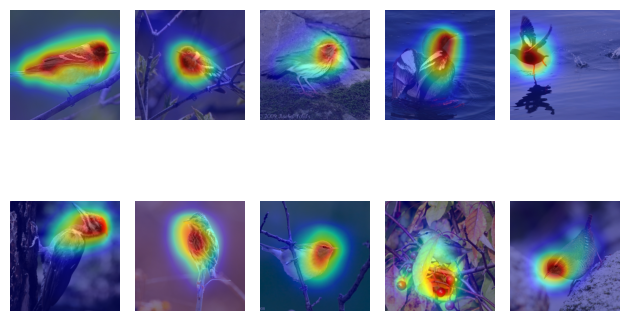

In [28]:

# loading the test images
imgs = glob.glob("handful_of_images/*.jpg")
len(imgs)

cam_extractor = SmoothGradCAMpp(model, target_layer="layer4")


def get_heat_map(fileNames, overlay):
    # getting the saliency maps on the images
    fig, ax = plt.subplots(2, 5, tight_layout=True)
    ax = ax.ravel()
    for i, img in enumerate(fileNames):
        input_image = Image.open(img)
        cropped_img = preprocess_visualise(input_image)

        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0)

        out = model(input_batch)
        cams = cam_extractor(out.squeeze(0).argmax().item(), out)

        if overlay:
            result = overlay_mask(
                to_pil_image(cropped_img), to_pil_image(cams[0].squeeze(0), mode="F"), alpha=0.5
            )
            ax[i].imshow(result)
            ax[i].set_axis_off()
        else:
            ax[i].imshow(cams[0].squeeze(0))
            ax[i].set_axis_off()

    plt.show()
get_heat_map(imgs, True)

cam_extractor.remove_hooks()


## IoU on saliency maps

In [29]:


Detection = namedtuple("Detection", ["image_path", "gt", "pred"])


def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


In [1]:


def IoU_saliency(fileNames, id, overlay):
    # ax = ax.ravel()
    for i, img in enumerate(fileNames):
        input_image = Image.open(img)
        cropped_img = preprocess_visualise(input_image)

        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0)

        out = model(input_batch)
        cams = cam_extractor(out.squeeze(0).argmax().item(), out)

        val = []
        for i in range(0, cams[0].squeeze(0).shape[0]):
            index, value = max(enumerate(cams[0].squeeze(0)[i]), key=operator.itemgetter(1))
            val.append(value)

        y_index, y_value = max(enumerate(val), key=operator.itemgetter(1))
        x_index, x_value = max(enumerate(cams[0].squeeze(0)[y_index]), key=operator.itemgetter(1))

        imz = Image.open(img).convert("F")
        wid, hei = imz.size

        cms = cams[0].squeeze(0).shape[0]

        x_ = wid // cms
        y_ = hei // cms
        x = (x_index) * x_
        y = (y_index) * y_

        examples = [
            Detection(
                fileNames[i], # TODO her er det lige hardcoded hvilket id det skal være - indsæt id som en parameter
                [bb[bb[0]==9286].values[0][1], bb[bb[0]==9286].values[0][2], bb[bb[0]==9286].values[0][1] + bb[bb[0]==9286].values[0][3] , bb[bb[0]==9286].values[0][2] + bb[bb[0]==9286].values[0][4] ],
                [(x - (wid // cms)), (y - (hei // cms)), (x + (wid // cms)), (y + (hei // cms))],
            )
        ]
        
        return examples




In [43]:

def IoU_saliency_display(fileNames, id):
    examples = IoU_saliency(imgs, 9286, True)

# loop over the example detections
    for detection in examples:
        # load the image
        image = cv2.imread(detection.image_path)
        # draw the ground-truth bounding box along with the predicted
        # bounding box
        cv2.rectangle(image, tuple(detection.gt[:2]), tuple(detection.gt[2:]), (0, 255, 0), 2)
        cv2.rectangle(
            image, tuple(detection.pred[:2]), tuple(detection.pred[2:]), (0, 0, 255), 2
        )
        # compute the intersection over union and display it
        iou = bb_intersection_over_union(detection.gt, detection.pred)
        cv2.putText(
            image,
            "IoU: {:.4f}".format(iou),
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 255, 0),
            2,
        )
        print("{}: {:.4f}".format(detection.image_path, iou))
        # show the output image
        cv2.imshow('iamge', image)
        cv2.waitKey(0)


IoU_saliency_display(imgs, 9286)
cam_extractor.remove_hooks()


handful_of_images/Pigeon_Guillemot_0109_39872.jpg: 0.0920
